## Setup PySpark

In [64]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, unix_timestamp, lag
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression

## Init Spark

In [65]:
spark = SparkSession.builder.appName("BitcoinPricePrediction").getOrCreate()

## Load Data

In [66]:
from elasticsearch import Elasticsearch

es = Elasticsearch(hosts=["http://localhost:9200"])

response = es.search(index="historical", body={
    "query": {
        "match_all": {}
    },
    "size": 1000  
})

data = [hit["_source"] for hit in response["hits"]["hits"]]

spark = SparkSession.builder.appName("BitcoinPricePrediction").getOrCreate()

training_df = spark.createDataFrame(data)

training_df.head()

Row(price='95146.52000000', symbol='btcusdt', time='2024-12-29T11:42:13.653000')

In [67]:
training_df.printSchema()

root
 |-- price: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- time: string (nullable = true)



## Convert Data

In [68]:

training_df = training_df.withColumn("time", to_timestamp(col("time")))

training_df = training_df.withColumn("time_numeric", unix_timestamp(col("time")))

training_df = training_df.withColumn("price", col("price").cast("double"))

training_df.head(2)

[Row(price=95146.52, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 13, 653000), time_numeric=1735472533),
 Row(price=95146.52, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 14, 824000), time_numeric=1735472534)]

In [69]:
training_df.printSchema()

root
 |-- price: double (nullable = true)
 |-- symbol: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- time_numeric: long (nullable = true)



## Feature Engineering


In [70]:
window_spec = Window.orderBy("time_numeric")

training_df = training_df.withColumn("prev_price", lag("price", 1).over(window_spec))

training_df = training_df.na.drop()

training_df.head(2)

25/01/30 13:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


[Row(price=95146.52, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 14, 824000), time_numeric=1735472534, prev_price=95146.52),
 Row(price=95147.64, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 17, 836000), time_numeric=1735472537, prev_price=95146.52)]

In [71]:
training_df.printSchema()

root
 |-- price: double (nullable = true)
 |-- symbol: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- time_numeric: long (nullable = true)
 |-- prev_price: double (nullable = true)



## Split Data

##### For time series models (such as Bitcoin predictions), randomSplit() is not ideal because future values are not randomly distributed. Instead, a rolling split should be used so that the model learns only from past data.

In [72]:
training_df = training_df.orderBy("time_numeric")

split_index = int(training_df.count() * 0.8)

train_data = training_df.limit(split_index)
test_data = training_df.subtract(train_data)


print(f"Train: {train_data.count()} rows, Test: {test_data.count()} rows")

25/01/30 13:13:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 1

Train: 799 rows, Test: 199 rows


## Vectorize

In [73]:
feature_cols = ["time_numeric", "prev_price"]
featureassembler=VectorAssembler(inputCols=feature_cols,outputCol="independent features")
train_data_output=featureassembler.transform(train_data)
print(train_data_output.show(5))
print(train_data_output.columns)

25/01/30 13:13:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------+-------+--------------------+------------+----------+--------------------+
|   price| symbol|                time|time_numeric|prev_price|independent features|
+--------+-------+--------------------+------------+----------+--------------------+
|95146.52|btcusdt|2024-12-29 11:42:...|  1735472534|  95146.52|[1.735472534E9,95...|
|95147.64|btcusdt|2024-12-29 11:42:...|  1735472537|  95146.52|[1.735472537E9,95...|
|95147.64|btcusdt|2024-12-29 11:42:...|  1735472537|  95147.64|[1.735472537E9,95...|
|95147.84|btcusdt|2024-12-29 11:42:...|  1735472537|  95147.64|[1.735472537E9,95...|
|95147.86|btcusdt|2024-12-29 11:42:...|  1735472539|  95147.84|[1.735472539E9,95...|
+--------+-------+--------------------+------------+----------+--------------------+
only showing top 5 rows

None
['price', 'symbol', 'time', 'time_numeric', 'prev_price', 'independent features']


## Prepare Data ML Model

In [74]:
scaler = MinMaxScaler(inputCol="independent features", outputCol="scaled_features")
scaler_model = scaler.fit(train_data_output)
train_data_output = scaler_model.transform(train_data_output)

train_data_output.select("independent features", "scaled_features").show(truncate=False)

25/01/30 13:13:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:13:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 1

+------------------------+------------------------------------------+
|independent features    |scaled_features                           |
+------------------------+------------------------------------------+
|[1.735472534E9,95146.52]|[0.0,0.9994814017329652]                  |
|[1.735472537E9,95146.52]|[0.0016233766233766235,0.9994814017329652]|
|[1.735472537E9,95147.64]|[0.0016233766233766235,0.9994970533109516]|
|[1.735472537E9,95147.64]|[0.0016233766233766235,0.9994970533109516]|
|[1.735472539E9,95147.84]|[0.0027056277056277055,0.9994998482355919]|
|[1.73547254E9,95147.86] |[0.003246753246753247,0.9995001277280562] |
|[1.73547254E9,95147.86] |[0.003246753246753247,0.9995001277280562] |
|[1.73547254E9,95147.84] |[0.003246753246753247,0.9994998482355919] |
|[1.73547254E9,95147.83] |[0.003246753246753247,0.9994997084893601] |
|[1.735472566E9,95147.63]|[0.017316017316017316,0.9994969135647195] |
|[1.735472566E9,95147.87]|[0.017316017316017316,0.9995002674742879] |
|[1.735472576E9,9514

In [75]:
finalized_data=train_data_output.select("scaled_features","price")
print(finalized_data.show(5))

25/01/30 13:14:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:14:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:14:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:14:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:14:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+--------+
|     scaled_features|   price|
+--------------------+--------+
|[0.0,0.9994814017...|95146.52|
|[0.00162337662337...|95147.64|
|[0.00162337662337...|95147.64|
|[0.00162337662337...|95147.84|
|[0.00270562770562...|95147.86|
+--------------------+--------+
only showing top 5 rows

None


## Train Model

In [76]:
regressor=LinearRegression(featuresCol="scaled_features",labelCol="price")
regressor=regressor.fit(finalized_data)

25/01/30 13:14:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:14:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:14:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:14:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:14:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:14:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 1

25/01/30 13:32:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:32:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:32:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:32:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/30 13:32:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


       independent features     price    prediction
0  [1735472534.0, 95146.52]  95146.52  95528.546295
1  [1735472537.0, 95146.52]  95147.64  95526.715894


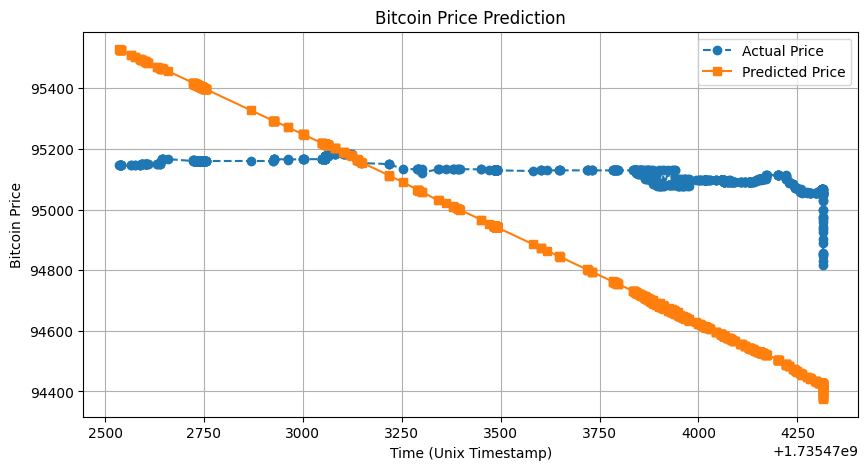

In [93]:
import matplotlib.pyplot as plt

predictions = regressor.transform(train_data_output)

pdf = predictions.select("independent features", "price", "prediction").toPandas().head(700)

print(pdf.head(2))

pdf["time"] = pdf["independent features"].apply(lambda x: x[0]) 
plt.figure(figsize=(10, 5))
plt.plot(pdf["time"], pdf["price"], label="Actual Price", marker="o", linestyle="dashed")
plt.plot(pdf["time"], pdf["prediction"], label="Predicted Price", marker="s", linestyle="solid")

plt.xlabel("Time (Unix Timestamp)")
plt.ylabel("Bitcoin Price")
plt.title("Bitcoin Price Prediction")
plt.legend()
plt.grid()
plt.show()

### price.diff() → Calculates price change
### signal.shift(1) → Uses the previous trading signal (avoiding future bias)
### .fillna(0) → Handles missing values
### Multiplication → Ensures profit is calculated only if a trade was made

In [100]:

pdf["signal"] = pdf["prediction"] > pdf["price"]

pdf["profit"] = pdf["price"].diff() * pdf["signal"].shift(1).fillna(0)

print(pdf.head(5))

total_earnings = pdf["profit"].sum()

print(total_earnings)

       independent features     price    prediction          time  signal  \
0  [1735472534.0, 95146.52]  95146.52  95528.546295  1.735473e+09    True   
1  [1735472537.0, 95146.52]  95147.64  95526.715894  1.735473e+09    True   
2  [1735472537.0, 95147.64]  95147.64  95526.954431  1.735473e+09    True   
3  [1735472537.0, 95147.64]  95147.84  95526.954431  1.735473e+09    True   
4  [1735472539.0, 95147.84]  95147.86  95525.776760  1.735473e+09    True   

  profit  
0    NaN  
1   1.12  
2    0.0  
3    0.2  
4   0.02  
25.179999999993015


In [61]:
print(f"Coefficients: {regressor.coefficients}")
print(f"Intercept: {regressor.intercept}")

Coefficients: [-1127.5268787138093,15240.47693149623]
Intercept: 80295.97304796432


In [85]:
regressor.save("regression_model version 1")